In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk
from keras import Model
from keras.layers import Input, Bidirectional, GlobalMaxPool1D, Dense, Dropout, LSTM, Flatten
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.optimizers import Adam
from keras import Model
from keras.layers import Input, Bidirectional, GlobalMaxPool1D, Dense, Dropout, LSTM, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc, average_precision_score
import seaborn as sb

# Project variables

In [2]:
m_name = "clickbait v1"
p_dir = os.path.join("../cb models", m_name)

In [3]:
def create_dir(dir_path: str):
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

In [4]:
def clear_dir(dir_path: str):
    for item in os.listdir(dir_path):
        fp = os.path.join(dir_path, item)
        if os.path.isfile(fp):
            os.remove(fp)
        if os.path.isdir(fp):
            rmtree(fp)

In [24]:
create_dir(p_dir)
clear_dir(p_dir)

# Prepare dataset

In [25]:
df = pd.read_csv("../cb models/clickbait_data.csv")
df.shape

(32000, 2)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headline   32000 non-null  object
 1   clickbait  32000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 500.1+ KB


In [27]:
# There are a few headlines longer than 100 characters. These are to be removed because the youtube titles have a max length of 100 characters.
df = df.loc[df.headline.str.len() <= 100, :]
df.rename(columns={"headline": "title"}, inplace=True)
df.shape

(31865, 2)

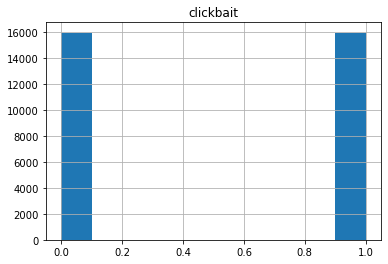

In [28]:
# How is the data distributed between clickbait and not clickbait?
df.hist()
plt.show()
# The data is about equally distributed between clickbaity and not

In [29]:
x = df.title
y = df.clickbait

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=4711)

x_train.to_pickle(os.path.join(p_dir, "x_train.pkl"))
y_train.to_pickle(os.path.join(p_dir, "y_train.pkl"))
x_val.to_pickle(os.path.join(p_dir,"x_val.pkl"))
y_val.to_pickle(os.path.join(p_dir, "y_val.pkl"))
x_test.to_pickle(os.path.join(p_dir,"x_test.pkl"))
y_test.to_pickle(os.path.join(p_dir, "y_test.pkl"))

print(x_train.shape[0], x_val.shape[0], x_test.shape[0])

19119 6373 6373


# Build the model

In [12]:
def preprocessing(df: pd.DataFrame, remove_stopwords: bool=False) -> pd.DataFrame:
    field = "title"
    stw = set(stopwords.words("english"))
    
    def cleanse_row(row, field, stw, stopwords=False):
        # Remove HTML from text
        soup = BeautifulSoup(row[field])
        row[field] = soup.get_text()
        
        # Remove stopwords
        if stopwords:
            row[field] = " ".join([w for w in row[field].split() if w not in stw])
        
        return row
    
    df = df.apply(lambda row: cleanse_row(row, field, stw, remove_stopwords), axis=1)
    return df["title"]

In [6]:
# Download the stopwork corpus
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
remove_stopwords = False

def preprocess_data(x: pd.DataFrame, remove_stopwords: bool=False) -> list():
    x_pp = preprocessing(x, remove_stopwords)
    x_pp = x_pp.tolist()
    return x_pp

In [8]:
x_train_pp = preprocess_data(x_train.to_frame())
x_val_pp = preprocess_data(x_val.to_frame())

NameError: name 'x_train' is not defined

In [9]:
pt_model = "distilbert-base-uncased"
tok = DistilBertTokenizer.from_pretrained(pt_model, do_lower=True, add_special_tokens=True, max_length=100, pad_to_max_length=True)

In [10]:
def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [], [], []
    for sentence in sentences:
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=100, padding="max_length", return_attention_mask=True, 
                                       return_token_type_ids=True)
        input_ids.append(inputs["input_ids"])
        input_masks.append(inputs["attention_mask"])
        input_segments.append(inputs["token_type_ids"])
        
    return np.asarray(input_ids, dtype="int32"), np.asarray(input_masks, dtype="int32"), np.asarray(input_segments, dtype="int32")

In [13]:
config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states=False
transformer_model = TFDistilBertModel.from_pretrained(pt_model, config=config)

in_ids = Input(shape=(100,), name="input_token", dtype="int32")
in_masks = Input(shape=(100,), name="masked_token", dtype="int32")

emb = transformer_model(in_ids, attention_mask=in_masks)[0]
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0))(emb)
x = GlobalMaxPool1D()(x)
x = Flatten()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(2, activation="softmax")(x)
model = Model(inputs=[in_ids, in_masks], outputs=x)

for layer in model.layers[:3]:
    layer.trainable = False

2021-11-04 19:14:17.873486: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-04 19:14:17.955252: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-04 19:14:17.956004: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-04 19:14:17.958307: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [14]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=Adam(learning_rate=0.0005), 
              metrics=["accuracy"])

In [37]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_1 (TFDisti TFBaseModelOutput(la 66362880    input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 100, 100)     327600      tf_distil_bert_model_1[0][0

In [38]:
x_train_tok = tokenize(x_train_pp, tok)
x_val_tok = tokenize(x_val_pp, tok)

lb = LabelBinarizer()
y_train_b = lb.fit_transform(y_train)
y_val_b = lb.transform(y_val)

batch_size = 64
n_epochs = 20

metric = "val_loss"

es = EarlyStopping(monitor=metric, 
                   mode="min", 
                   patience=5, 
                   restore_best_weights=True)

checkpoint = ModelCheckpoint(os.path.join(p_dir, "{}".format(m_name)), 
                             monitor=metric, 
                             verbose=2, 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min')

hist = model.fit(x_train_tok[:2], y_train_b, 
                 validation_data=(x_val_tok[:2], y_val_b), 
                 batch_size=batch_size, 
                 epochs=n_epochs, 
                 callbacks=[checkpoint, es])

Epoch 1/20
299/299 [==============================] - 97s 303ms/step - loss: 0.1215 - accuracy: 0.9552 - val_loss: 0.0672 - val_accuracy: 0.9760

Epoch 00001: val_loss improved from inf to 0.06716, saving model to ../cb models/clickbait v1/clickbait v1
Epoch 2/20
299/299 [==============================] - 89s 297ms/step - loss: 0.0697 - accuracy: 0.9755 - val_loss: 0.0625 - val_accuracy: 0.9772

Epoch 00002: val_loss improved from 0.06716 to 0.06253, saving model to ../cb models/clickbait v1/clickbait v1
Epoch 3/20
299/299 [==============================] - 89s 296ms/step - loss: 0.0568 - accuracy: 0.9805 - val_loss: 0.0999 - val_accuracy: 0.9661

Epoch 00003: val_loss did not improve from 0.06253
Epoch 4/20
299/299 [==============================] - 89s 297ms/step - loss: 0.0473 - accuracy: 0.9823 - val_loss: 0.0517 - val_accuracy: 0.9818

Epoch 00004: val_loss improved from 0.06253 to 0.05170, saving model to ../cb models/clickbait v1/clickbait v1
Epoch 5/20
299/299 [================

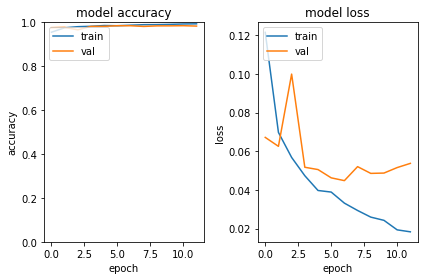

In [39]:
fig, axs = plt.subplots(1, 2)

axs[0].plot(hist.history["accuracy"])
axs[0].plot(hist.history["val_accuracy"])
axs[0].set_title("model accuracy")
axs[0].set_ylabel("accuracy")
axs[0].set_xlabel("epoch")
axs[0].set_ylim(0, 1)
axs[0].legend(["train", "val"], loc="upper left")

axs[1].plot(hist.history["loss"])
axs[1].plot(hist.history["val_loss"])
axs[1].set_title("model loss")
axs[1].set_ylabel("loss")
axs[1].set_xlabel("epoch")
# axs[1].set_ylim(0, 1)
axs[1].legend(["train", "val"], loc="upper left")

plt.tight_layout()
plt.show()
fig.savefig(os.path.join(p_dir, "accuracy_loss.jpg"))

# Confusion matrix

In [15]:
model.load_weights(os.path.join(p_dir, "{}".format(m_name)))

## Validation data (in-sample)

In [41]:
x_val_tok = tokenize(x_val_pp, tok)

lb = LabelBinarizer()
y_train_b = lb.fit_transform(y_train)
y_val_b = lb.transform(y_val)

y_val_prob = model.predict(x_val_tok[:2], steps=y_val_b.shape[0])
y_pred = np.argmax(y_val_prob, axis=1)
y_pred = lb.inverse_transform(y_pred)

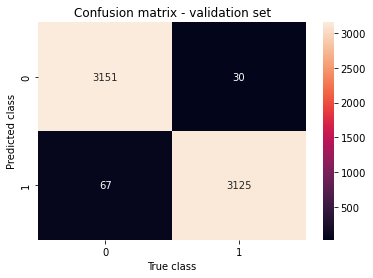

Accuracy: 0.98
Micro precision: 0.98
Micro recall: 0.98
Micro F1-score: 0.98
Macro precision: 0.98
Macro recall: 0.98
Macro F1-score: 0.98
Weighted precision: 0.98
Weighted recall: 0.98
Weighted F1-score: 0.98


In [45]:
cmtx = confusion_matrix(y_val, y_pred)
sb.heatmap(cmtx, annot=True, fmt="d", xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.xlabel("True class")
plt.ylabel("Predicted class")
plt.title("Confusion matrix - validation set")
plt.savefig(os.path.join(p_dir, "confusion_matrix_val.jpg"))
plt.show()

print("Accuracy: {:0.2f}".format(accuracy_score(y_val, y_pred)))

print("Micro precision: {:0.2f}".format(precision_score(y_val, y_pred, average="micro")))
print("Micro recall: {:0.2f}".format(recall_score(y_val, y_pred, average="micro")))
print("Micro F1-score: {:0.2f}".format(f1_score(y_val, y_pred, average="micro")))

print("Macro precision: {:0.2f}".format(precision_score(y_val, y_pred, average="macro")))
print("Macro recall: {:0.2f}".format(recall_score(y_val, y_pred, average="macro")))
print("Macro F1-score: {:0.2f}".format(f1_score(y_val, y_pred, average="macro")))

print("Weighted precision: {:0.2f}".format(precision_score(y_val, y_pred, average="weighted")))
print("Weighted recall: {:0.2f}".format(recall_score(y_val, y_pred, average="weighted")))
print("Weighted F1-score: {:0.2f}".format(f1_score(y_val, y_pred, average="weighted")))

# print(classification_report(y_val, y_pred, target_names=lb.classes_))

## Test data (out-of-sample)

In [46]:
x_test_pp = preprocess_data(x_test.to_frame())
x_test_tok = tokenize(x_test_pp, tok)

lb = LabelBinarizer()
y_train_b = lb.fit_transform(y_train)
y_test_b = lb.transform(y_test)

y_test_prob = model.predict(x_test_tok[:2], steps=y_test_b.shape[0])
y_pred = np.argmax(y_test_prob, axis=1)
y_pred = lb.inverse_transform(y_pred)

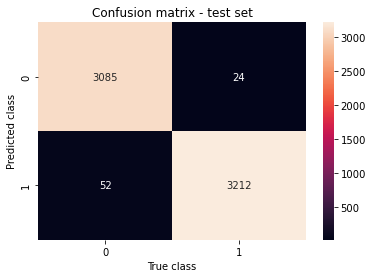

Accuracy: 0.99
Micro precision: 0.99
Micro recall: 0.99
Micro F1-score: 0.99
Macro precision: 0.99
Macro recall: 0.99
Macro F1-score: 0.99
Weighted precision: 0.99
Weighted recall: 0.99
Weighted F1-score: 0.99


In [48]:
cmtx = confusion_matrix(y_test, y_pred)
sb.heatmap(cmtx, annot=True, fmt="d", xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.xlabel("True class")
plt.ylabel("Predicted class")
plt.title("Confusion matrix - test set")
plt.savefig(os.path.join(p_dir, "confusion_matrix_test.jpg"))
plt.show()

print("Accuracy: {:0.2f}".format(accuracy_score(y_test, y_pred)))

print("Micro precision: {:0.2f}".format(precision_score(y_test, y_pred, average="micro")))
print("Micro recall: {:0.2f}".format(recall_score(y_test, y_pred, average="micro")))
print("Micro F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="micro")))

print("Macro precision: {:0.2f}".format(precision_score(y_test, y_pred, average="macro")))
print("Macro recall: {:0.2f}".format(recall_score(y_test, y_pred, average="macro")))
print("Macro F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="macro")))

print("Weighted precision: {:0.2f}".format(precision_score(y_test, y_pred, average="weighted")))
print("Weighted recall: {:0.2f}".format(recall_score(y_test, y_pred, average="weighted")))
print("Weighted F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="weighted")))

# print(classification_report(y_test, y_pred, target_names=lb.classe_))

# ROC curve

## Validation data (in-sample)

In [49]:
lb = LabelBinarizer()
lb.fit_transform(y_train)

y_val_no = lb.fit_transform(y_val)
y_pred_no = y_val_prob[:, 1]
fpr, tpr, thr = roc_curve(y_val_no, y_pred_no)

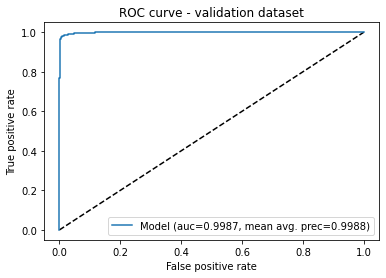

In [50]:
auc_model = auc(fpr, tpr)
mavgp = average_precision_score(y_val_no, y_pred_no)

plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr, label="Model (auc={:0.4f}, mean avg. prec={:0.4f})".format(auc_model, mavgp))
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve - validation dataset")
plt.legend()
plt.savefig(os.path.join(p_dir, "roc-curve_val.jpg"))
plt.show()

## Test data (out-of-sample)

In [51]:
lb = LabelBinarizer()
lb.fit_transform(y_train)

y_test_no = lb.fit_transform(y_test)
y_pred_no = y_test_prob[:, 1]
fpr, tpr, thr = roc_curve(y_test_no, y_pred_no)

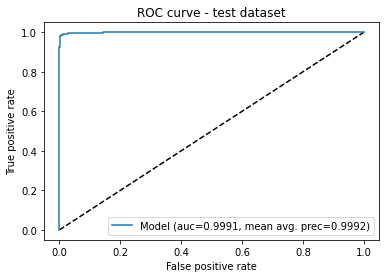

In [52]:
auc_model = auc(fpr, tpr)
mavgp = average_precision_score(y_test_no, y_pred_no)

plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr, label="Model (auc={:0.4f}, mean avg. prec={:0.4f})".format(auc_model, mavgp))
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve - test dataset")
plt.legend()
plt.savefig(os.path.join(p_dir, "roc-curve_test.jpg"))
plt.show()

# Class probability histograms

## Without middle classes

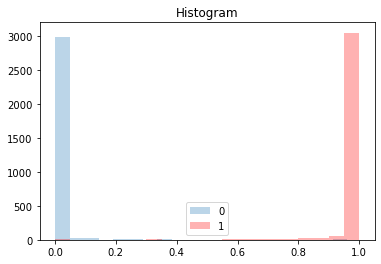

In [54]:
m0 = y_test_no[:, 0] == 0
c0 = y_test_prob[m0, 1]
m1 = y_test_no[:, 0] == 1
c1 = y_test_prob[m1, 1]

plt.hist(c0, alpha=0.3, bins=20)
plt.hist(c1, color="red", alpha=0.3, bins=20)
plt.title("Histogram")
plt.legend(lb.classes_)
plt.savefig(os.path.join(p_dir, "histogram.jpg"))
plt.show()

# Sample titles

In [55]:
combo = pd.concat([x_test, y_test], axis=1)
combo.reset_index(drop=True, inplace=True)
combo = pd.concat([combo, pd.Series(y_pred, name="pred")], axis=1)
combo.rename(columns={"clickbait": "truth"}, inplace=True)
combo.shape

(6373, 3)

In [56]:
g = combo.groupby(["pred"], as_index=False).apply(lambda x: x.sample(5, random_state=682))
g[["title", "pred"]].head(10)
g.to_csv(os.path.join(p_dir, "titles.csv"), index=False)
g.head(10)

title  truth  pred
0 4908                     Journalists deported from Fiji      0     0
  5835  Indian foreign minister criticized after readi...      0     0
  3163                    The Evolution Of Natalie Dormer      1     0
  4624  With Digital Foci, Carry Your Slide Show With You      0     0
  2393                  Two strong earthquakes jolt Japan      0     0
1 916   This Phone Is For Everyone Who Always Runs Out...      1     1
  814   Natalie Portman Looks Exactly Like Jackie Kenn...      1     1
  4203      What's Your Horoscope For The Week Of Oct. 19      1     1
  2598  How To Make An Easy Skillet Sweet Potato Frittata      1     1
  3151  This 3 Minute Christmas Hallmark Movie Is Hila...      1     1

# Save test set pred

In [57]:
y_pred_test = pd.Series(y_pred, name="y_pred_test")
y_pred_test.to_pickle(os.path.join(p_dir, "y_pred_test.pkl"))

# Apply model on Youtube data

In [81]:
import pandas as pd
import os
import numpy as np

In [82]:
m_dir = r"../nlp models/distilbert_2_classes_v3"

x_alien = pd.read_pickle(os.path.join(m_dir, "x_train.pkl"))
y_alien = pd.read_pickle(os.path.join(m_dir, "y_train.pkl"))

In [83]:
x_alien_pp = preprocess_data(x_alien)
x_alien_tok = tokenize(x_alien_pp, tok)

y_alien_prob = model.predict(x_alien_tok[:2], steps=y_alien_b.shape[0])
y_pred = np.argmax(y_alien_prob, axis=1)

In [84]:
x_combo = pd.concat([x_alien.reset_index(), y_alien.reset_index(), pd.Series(y_pred, name="pred")], axis=1)

In [96]:
x_combo[["title", "qtl", "pred"]].iloc[412:418, :]

,title,qtl,pred
412,This is why we can't have nice things,very high,1
413,Spring Full Course - Learn Spring Framework In...,very low,1
414,Platinum (version 2) - Periodic Table of Videos,very high,0
415,When To Quit (According to Computer Science),very high,1
416,Have astronomers disproved the Big Bang?,very high,0
417,Outtakes #1: Crash Course Philosophy,very low,1


In [94]:
x_combo["y"] = (x_combo["qtl"] == "very high").astype("int32")
x_combo["y"].corr(x_combo["pred"])

0.14178025660879123